In [1]:
import numpy as np, sympy as sp, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn import preprocessing

np.random.seed = 1234

sp.init_printing(use_latex='mathjax')
%matplotlib inline

# Exploratory part

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [3]:
test.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color
0,3,0.471774,0.387937,0.706087,0.698537,black
1,6,0.427332,0.645024,0.565558,0.451462,white
2,9,0.549602,0.491931,0.660387,0.449809,black
3,10,0.638095,0.682867,0.471409,0.356924,white
4,13,0.361762,0.583997,0.377256,0.276364,black


In [4]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [5]:
train.dtypes

id                 int64
bone_length      float64
rotting_flesh    float64
hair_length      float64
has_soul         float64
color             object
type              object
dtype: object

## Visualization

In [6]:
colorenc = preprocessing.LabelEncoder()
colorenc.fit(pd.concat((test['color'], train['color'])))
test['color'] = colorenc.transform(test['color'])
train['color'] = colorenc.transform(train['color'])


/home/god/py/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


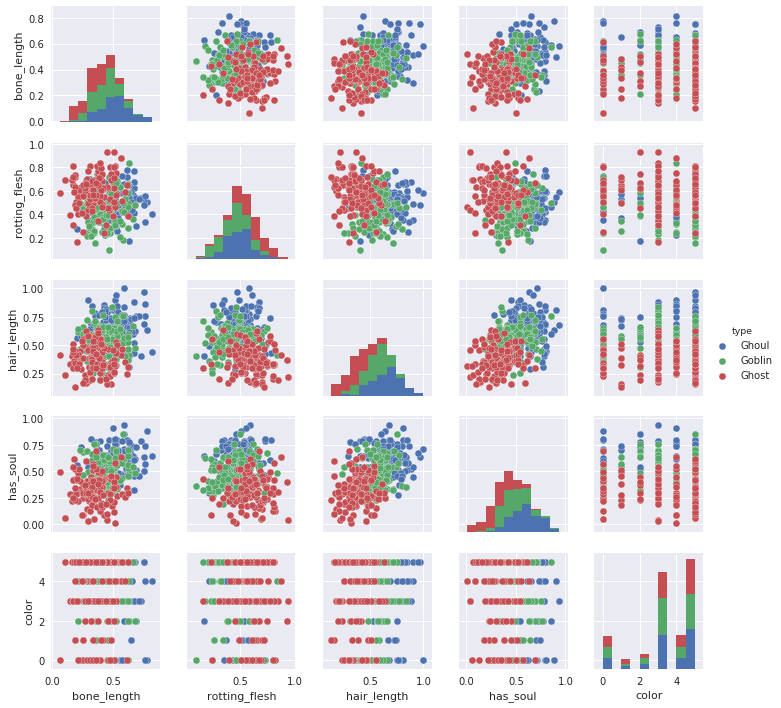

In [7]:
sns.pairplot(train.drop('id', axis=1), size=2, hue='type')
# plt.savefig('monsters_distribution.png', dpi=1200)

From these plots one can see that the classes
are quite separated and form ellipsoid-like clusters
(though some of them are rather concave)
and the intuitive decision boundaries
can be linearized by introducing **polynomial features** of degree $3$. Then simple **logistic regression** or more complex model like **random forest** can be applied.

It is also obvious from visualization
that **K-nearest-neighbours** and **kernel density estimates** would give pretty good results.

# Building predictive models
## Simplest logit

In [8]:
monsterenc = preprocessing.LabelEncoder()
monsterenc.fit(train['type'])
train['type'] = monsterenc.transform(train['type'])

In [9]:
clrbinarizer = preprocessing.LabelBinarizer()
clrs_tr = clrbinarizer.fit_transform(train['color'], )
clrs_te = clrbinarizer.transform(test['color'])
train = pd.concat([train.drop('color', axis=1),
           pd.DataFrame(clrs_tr,
                        columns=colorenc.inverse_transform(
                            clrbinarizer.classes_))
          ], axis=1)
test = pd.concat([test.drop('color', axis=1),
           pd.DataFrame(clrs_te,
                        columns=colorenc.inverse_transform(
                            clrbinarizer.classes_))
          ], axis=1)

In [21]:
from sklearn.model_selection import cross_val_score
poly_features = preprocessing.PolynomialFeatures(3)

X_tr, y_tr = train.drop(['id', 'type'], axis=1), train['type']
X_tr = poly_features.fit_transform(X_tr)

In [22]:
from sklearn.linear_model import LogisticRegression

typelogfit = LogisticRegression()
scores = cross_val_score(typelogfit, X_tr, y_tr)
# for simplicity, let's train on the whole set
typelogfit.fit(X_tr, y_tr)
print('scores: %s\nmean score: %s' % (scores, scores.mean()))
print('coefs l2 norms: %s' % np.sqrt(
    typelogfit.coef_.dot(
        typelogfit.coef_.transpose()).diagonal()))

scores: [ 0.70967742  0.74193548  0.69105691]
mean score: 0.714223271265
coefs l2 norms: [ 6.269946    4.84169255  4.08743227]


In [12]:
X_te = poly_features.fit_transform(test.drop(['id'], axis=1))
y_te = typelogfit.predict(X_te)
ans_logit = pd.DataFrame({'id': test['id'], 'type': monsterenc.inverse_transform(y_te)})
ans_logit.to_csv('ans_logit.csv', index=False)
ans_logit.head()

,id,type
0,3,Ghoul
1,6,Ghost
2,9,Ghoul
3,10,Ghost
4,13,Ghost


Even this quite primitive technique performed surprisingly well!
The kaggle scored this solution $0.73724$ which is close
to the output of `cross_val_score`

Now let's see what else can be told about the quality of our model

/home/god/py/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


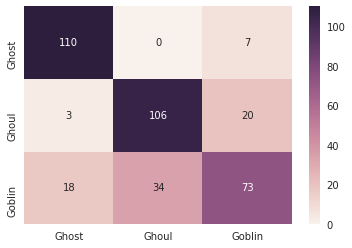

In [13]:
from sklearn.metrics import confusion_matrix
y_tr_pr = typelogfit.predict(X_tr)
cm = pd.DataFrame(confusion_matrix(y_tr, y_tr_pr),
                  index=monsterenc.classes_,
                  columns=monsterenc.classes_)
sns.heatmap(cm, annot=True, fmt="d")

## Nearest Neighbours models

/home/god/py/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/god/py/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


score: 0.7196765498652291
n_neighbors: 60
weights: distance
better to use $l\_2 $-norm


/home/god/py/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


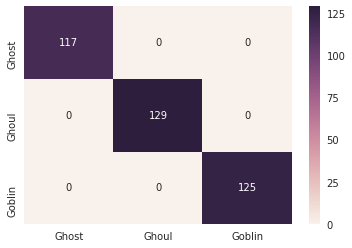

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
X_tr, y_tr = train.drop(['id', 'type'], axis=1), train['type']
scale = preprocessing.StandardScaler()
X_tr = scale.fit_transform(X_tr)

knn = KNeighborsClassifier()
grid = GridSearchCV(knn,
                    param_grid={
                        'weights': ['uniform', 'distance'],
                        'n_neighbors': list(range(1,101,1)),
                        'p': [1,2]
                    })
grid.fit(X_tr, y_tr)
print('score: %s' % grid.best_score_)
print('n_neighbors: %s' % grid.best_estimator_.n_neighbors)
print('weights: %s' % grid.best_estimator_.weights)
print('better to use $l\\_%s $-norm' % grid.best_estimator_.p)
y_tr_pr = grid.predict(X_tr)
cm = pd.DataFrame(confusion_matrix(y_tr, y_tr_pr),
                  index=monsterenc.classes_,
                  columns=monsterenc.classes_)
sns.heatmap(cm, annot=True, fmt="d")

In [15]:
X_te = scale.transform(test.drop('id', axis=1))
y_te = grid.predict(X_te)
ans_knn = pd.DataFrame({'id': test['id'], 'type': monsterenc.inverse_transform(y_te)})
ans_knn.to_csv('ans_knn.csv', index=False)
ans_knn.head()

,id,type
0,3,Ghoul
1,6,Goblin
2,9,Ghoul
3,10,Ghost
4,13,Ghost


This model seems to be a bit more reasonable,
kaggle scored it $0.74480$.

,id,bone_length,rotting_flesh,hair_length,has_soul,type,black,blood,blue,clear,green,white
0,0,0.354512,0.350839,0.465761,0.781142,1,0,0,0,1,0,0
1,1,0.575560,0.425868,0.531401,0.439899,2,0,0,0,0,1,0
2,2,0.467875,0.354330,0.811616,0.791225,1,1,0,0,0,0,0
3,4,0.776652,0.508723,0.636766,0.884464,1,1,0,0,0,0,0
4,5,0.566117,0.875862,0.418594,0.636438,0,0,0,0,0,1,0
